# Exercise X: Gradient analysis of a neural network

You have already learnt to train a neural network and to evaluate its perfomance. In this exercise, you will analyze a neural network more closely. The output of the neural network is a function of the input quantities and Tensorflow enables you to derive gradients of it. The training algorithm uses gradients with respect to the NN parameters for given inputs defined by the training set. The other way round, we are going to derive gradients with respect to the input quantities for the given NN parameters determined by the training in order to get an idea how the NN output depends on the respective inputs and what their relevance is. It can also be understood as evaluating the leading orders of a Taylor Expansion of the NN output around the data points.

As you know already, you should usually get a basic overview of the input data before you apply multivariate analysis techniques. This is often limited by the complexity of the given data and advanced analysis techniques like the gradient analysis may help you to complete the picture. In this example however, the input data is of rather simple structure and we won't take a look at the beginning in order to pretend that it is more complex. We will make plots later on in order to verify the conclusions that we made from the gradient analysis.

The dataset contains two event classes (signal and background) that we want to optimally classify. There are three observables that can be use for this purpose.

To guide your own implementation of studies of the data-set, a code basis is provided in this jupyter notebook. Inspect it and use it as a starting point for your own work. 

Import the packages needed for this exercise:

In [1]:
# Importing usual python packages
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [ ]:
#%%capture output
# Importing ML related packages. 
import tensorflow
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils

In [3]:
# check the tensorflow version we are using. Should be 2.2.0
print(tensorflow.__file__)
print(tensorflow.__version__)

/home/ubuntuuser/.local/lib/python3.8/site-packages/tensorflow/__init__.py
2.2.0


Import the dataset. It consists of 10000 signal and background events respectively for the training. The same amount of events is available as test set. The first three columns contain the observables. The forth column contains the truth label (see mapping below).

In [6]:
# load data
data = np.loadtxt('events.data')
np.random.shuffle(data) #input data are sorted by class and Keras takes the last X% of the input data as validation set
data_variables = np.array(data[:, :3])
labels = data[:, 3]
bckgrd = labels==0
signal = labels==1
training_set = labels<2
bckgrd_test = labels==2
signal_test = labels==3
test_set = labels>=2

## Exercise X.1: Training and retrieval of gradients (obligatory)
For this relatively simple training task we use a small NN as defined in the following. Run the training.

<span style="color:red">Provided to students assuming that this follows NN exercise with number recognition. Otherwise this could be more focussed on.</span>

In [7]:
def train():
    # Select training data
    input_variables = data_variables[training_set]
    input_labels = labels[training_set]

    # Set up model
    model = Sequential()
    model.add(Dense(100, activation = 'tanh', input_dim = 3))
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Define loss function, optimizer algorithm and validation metrics
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['acc'])

    # Print summary of the model
    model.summary()

    # Train model
    history = model.fit(input_variables, input_labels, batch_size=1024, epochs=50, validation_split=0.25)

    # Get training and validation loss/accuracy values from history
    loss_training = history.history['loss']
    loss_validation = history.history['val_loss']
    accuracy_training = history.history['acc']
    accuracy_validation = history.history['val_acc']

    # TODO: Plot the training and validation loss/accuracy vs the number of epochs
    plt.plot(accuracy_training)
    plt.plot(accuracy_validation)
    plt.savefig('loss_vs_epochs.png')   
    
    # Save model to file
    model.save('model.hd5')
    
    return

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
15/15 [==============================] - 1s 42ms/step - loss: 0.7155 - acc: 0.4997 - val_loss: 0.6885 - val_acc: 0.5128
Epoch 2/50
15/15 [==============================] - 0s 14ms/step - loss: 0.6796 - acc: 0.5333 - val_loss: 0.6649 - val_acc: 0.6176
Epoch 3/50
15/15 [==============================] - 0s 23ms/step - loss: 0.6575 - acc: 0.6466 - val_loss: 0.6464 - val_acc: 0.6628
Epoch 4/50
15/15 [==============================] - 0s 15ms/step - loss: 0.6415 - acc: 0.6610 - val_loss: 0.6312 - val_acc: 0.6

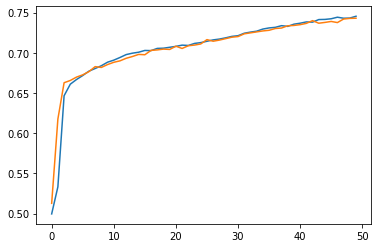

In [8]:
train()

Apply the NN to the test data and plot a histogram of the resulting distributions in order to get a visual impression of the output distributions:

<span style="color:red">Make students used to such output distributions and make them check the result.</span>

In [9]:
def apply(events, modelfile='model.hd5'):
    # Load trained keras model
    model = load_model(modelfile)
    
    # Pass events through model
    predictions = model.predict(events)
    return predictions

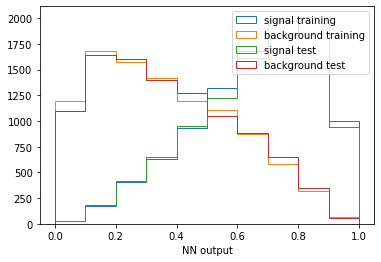

In [15]:
pred = apply(data_variables)

plt.hist(pred[signal], histtype=u'step', bins=10, range=(0,1), label="signal training")
plt.hist(pred[bckgrd], histtype=u'step', bins=10, range=(0,1), label="background training")
plt.hist(pred[signal_test], histtype=u'step', bins=10, range=(0,1), label="signal test")
plt.hist(pred[bckgrd_test], histtype=u'step', bins=10, range=(0,1), label="background test")
plt.xlabel("NN output")
plt.legend()

plt.show()


The following code shows you how the gradient can be retrieved with a tensorflow gradient tape. It tells tensorflow with respect to which parameters of the NN tensor the gradient shall be calculated (The input observables in this case).
With the given loop, the gradient will be evaluated at each data point of the test set and the mean result will be printed at the end. This tells you how the NN output responds on average to variations of the input observables. Run the code and get the mean gradient.

<span style="color:red">Show students a way to retrieve gradients wrt. to certain variables from the NN.</span>

In [16]:
model = load_model('model.hd5')
mean_grads = [0.0, 0.0, 0.0]
n_evts = len(data_variables[test_set])
fraction = 10 #run only every nth event for saving time
for n, event in enumerate(data_variables[test_set]):
    if n%fraction!=0:
        continue
    with tensorflow.GradientTape() as tape: #https://www.tensorflow.org/guide/advanced_autodiff#higher-order_gradients
        inputs = tensorflow.Variable([event])
        tape.watch(inputs)
        output = model(inputs)
    g = tape.gradient(output, inputs)
    grads = g.numpy()[0]
    for i in range(len(mean_grads)):
        mean_grads[i] += grads[i]/n_evts*fraction
print(mean_grads)

[0.37873838176159175, 0.006491995414326087, -0.0012634340524382416]


The mean gradient contains one component for each input observable.
- What does the result tell you?
- What is the drawback of this calculated mean gradient? How can it be improved? Only a small adaptation of the given code is necessary. Apply and rerun it.
- What additional information can you get from the new result?

<span style="color:red">Make students think about the effect of averaging the gradients and how information could be gained from the gradients in all the points. The first naive approach suffers from annihilation of positive and negative values, such that variables can seem meaningless despite they are not. Applying abs() reveals that this is the case for the second variable.</span>

In [17]:
model = load_model('model.hd5')
mean_grads = [0.0, 0.0, 0.0]
n_evts = len(data_variables[test_set])
fraction = 10 #run only every nth event for saving time
for n, event in enumerate(data_variables[test_set]):
    if n%fraction!=0:
        continue
    with tensorflow.GradientTape() as tape: #https://www.tensorflow.org/guide/advanced_autodiff#higher-order_gradients
        inputs = tensorflow.Variable([event])
        tape.watch(inputs)
        output = model(inputs)
    g = tape.gradient(output, inputs)
    grads = g.numpy()[0]
    for i in range(len(mean_grads)):
        mean_grads[i] += abs(grads[i])/n_evts*fraction
print(mean_grads)

[0.37873838176159175, 0.15278198220809297, 0.005435103076597447]


You can also calculate higher derivatives with tensorflow. In order to go to the second order, you can encapsulate the present gradient tape with a second one and retrieve the jacobian matrix via `jacobian = tape2.jacobian(g, inputs).numpy()`. Note that the resulting numpy array will have effectively two dimensions but like for the gradient you need to call the zeroth component in between `jacobian[0][i][0][j]`. Calculate the second derivatives given by the diagonal elements. What do they tell you and how does that relate to the observation you made with the first order gradients?

<span style="color:red">Obviously the second derivative tells whether the impact of a variable is constant or depends on the phase space region. Students should realize that the presence of positive and negative gradients as observed before is typically related to high second order derivatives. If students also think about edge cases, even better...</span>

In [18]:
model = load_model('model.hd5')
mean_grads = [0.0, 0.0, 0.0]
mean_jacobian = [0.0, 0.0, 0.0]
n_evts = len(data_variables[test_set])
fraction = 10 #run only every nth event for saving time
for n, event in enumerate(data_variables[test_set]):
    if n%fraction!=0:
        continue
    with tensorflow.GradientTape() as tape2:
        with tensorflow.GradientTape() as tape: #https://www.tensorflow.org/guide/advanced_autodiff#higher-order_gradients
            inputs = tensorflow.Variable([event])
            tape.watch(inputs)
            tape2.watch(inputs)
            output = model(inputs)
        g = tape.gradient(output, inputs)
        grads = g.numpy()[0]
    jacobian = tape2.jacobian(g, inputs).numpy()[0]
    for i in range(len(mean_grads)):
        mean_grads[i] += abs(grads[i])/n_evts*fraction
        mean_jacobian[i] += abs(jacobian[i][0][i])/n_evts*fraction
print(mean_grads)
print(mean_jacobian)

[0.37873838176159175, 0.15278198220809297, 0.005435103076597447]
[0.28700176966906316, 0.2778135639620015, 0.010042237276997192]


Now it is time to verify your assumptions about the data distributions. Let's create a 3x3 matrix of plots of the three observables (marginal distributions on the diagonal, 2D scatter plots on the off-diagonal elements).

<span style="color:red">The conclusions drawn so far will hopefully match the plots. Students should think about whether the retrieved gradent results fit the observed distributions. If students should practice plotting (thinking of what to plot and verify that it is done correctly), provided code could be removed. </span>


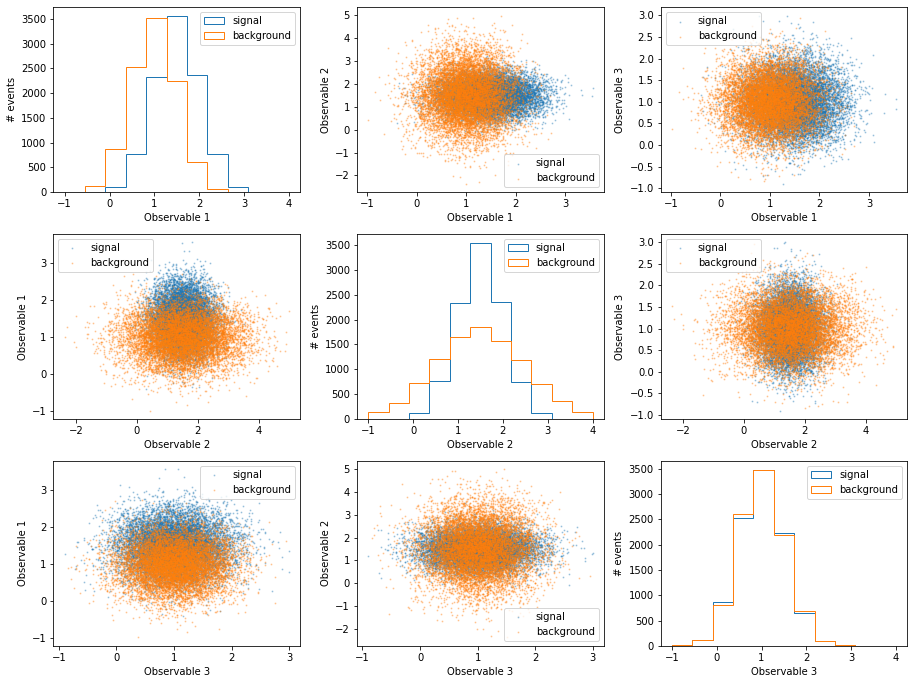

In [19]:
nvar = 3
f, axarr = plt.subplots(nvar, nvar, figsize=[12.8, 9.6])
nbins = 20
for i in range(nvar):
    for j in range(nvar):
        if i==j:
            axarr[i,j].hist(data[signal_test,i], histtype=u'step', bins=11, range=(-1,4), label="signal")
            axarr[i,j].hist(data[bckgrd_test,i], histtype=u'step', bins=11, range=(-1,4), label="background")
            axarr[i,j].legend()
            axarr[i,j].set_xlabel("Observable %i"%(i+1))
            axarr[i,j].set_ylabel("# events")
        else:
            axarr[i,j].scatter(data[signal_test,i],data[signal_test,j], s=1, alpha=0.3, label="signal")
            axarr[i,j].scatter(data[bckgrd_test,i],data[bckgrd_test,j], s=1, alpha=0.3, label="background")
            axarr[i,j].legend()
            axarr[i,j].set_xlabel("Observable %i"%(i+1))
            axarr[i,j].set_ylabel("Observable %i"%(j+1))
plt.tight_layout()
plt.show()

## Exercise X.2: ROC curves (obligatory)
In this part of the exercise, you will generate ROC curves in order to visualize the separation power of the single observables and the NN output. Finally, compare it to the information you retrieved with the gradient analysis.

The following function already provides the functionality to transform two histrograms (signal and background) handed over as a list of bin contents into ROC plots. Recall what it does and what a ROC curve shows.

In the second code block, define the histograms to be fed into the function for each of the observables and the NN output generating altogether four ROC curves. One example is already given. In one case, you will need to apply a simple transformation to the observable in order to get a sensible results. You can apply the necessary operations like `abs()+-*/` directly to the numpy array that holds the data.

<span style="color:red">Make students think about what ROC curves are and how they can be generated. Code is provided since quite a few things could be messed up here. However, make them define the discriminators. Since the second quantitiy is peaking, one needs to apply abs(x-mean) to obtain a good discriminator. In the result, one can see how the different variables separate different portions of the events (different curve shapes) and that the NN combines all the separation power resulting in an envelope.</span>

In [21]:
def plot_ROC(y_sig, y_bkg, label):
    #Choose the direction of the discriminating varible such that AUC is > 50%
    mean = 0.0
    for i in range(len(y_sig)):
        mean += i * (y_sig[i] - y_bkg[i])
    if mean > 0.0:
        y_sig = y_sig[::-1] #reverse numpy array
        y_bkg = y_bkg[::-1] #reverse numpy array
    
    sigeff = [0.0]
    bkgeff = [0.0]
    for y, eff in [[y_sig, sigeff], [y_bkg, bkgeff]]:
        for entry in y:
            eff.append(entry + eff[-1])
        for i, entry in enumerate(eff):
            eff[i] = entry / eff[-1]
    bkgrej=[]
    for entry in bkgeff:
        bkgrej.append(1.0 - entry)
    
    plt.plot(sigeff, bkgrej, label=label)

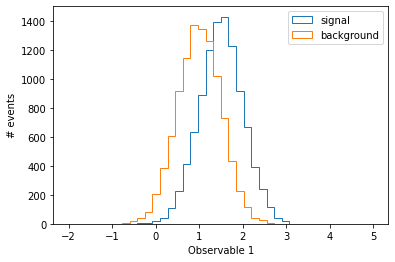

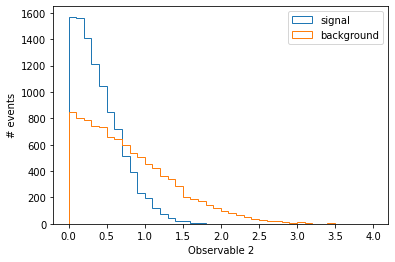

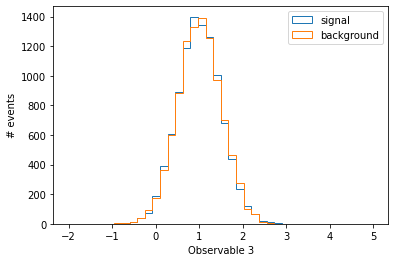

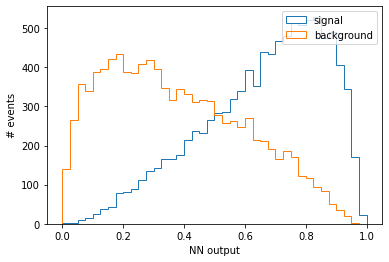

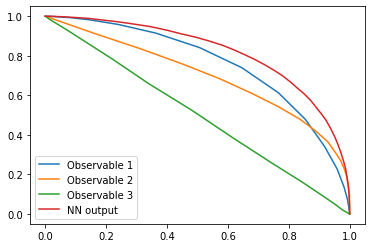

In [23]:
y1sig, x1sig, p1sig = plt.hist(data[signal_test,0], histtype=u'step', bins=40, range=(-2,5), label="signal")
y1bkg, x1bkg, p1bkg = plt.hist(data[bckgrd_test,0], histtype=u'step', bins=40, range=(-2,5), label="background")
plt.legend()
plt.xlabel("Observable 1")
plt.ylabel("# events")
plt.show()
y2sig, x2sig, p2sig = plt.hist(abs(data[signal_test,1]-1.5), histtype=u'step', bins=40, range=(0,4), label="signal")
y2bkg, x2bkg, p2bkg = plt.hist(abs(data[bckgrd_test,1]-1.5), histtype=u'step', bins=40, range=(0,4), label="background")
plt.legend()
plt.xlabel("Observable 2")
plt.ylabel("# events")
plt.show()
y3sig, x3sig, p3sig = plt.hist(data[signal_test,2], histtype=u'step', bins=40, range=(-2,5), label="signal")
y3bkg, x3bkg, p3bkg = plt.hist(data[bckgrd_test,2], histtype=u'step', bins=40, range=(-2,5), label="background")
plt.legend()
plt.xlabel("Observable 3")
plt.ylabel("# events")
plt.show()
y4sig, x4sig, p4sig = plt.hist(pred[signal_test], histtype=u'step', bins=40, range=(0,1), label="signal")
y4bkg, x4bkg, p4bkg = plt.hist(pred[bckgrd_test], histtype=u'step', bins=40, range=(0,1), label="background")
plt.legend()
plt.xlabel("NN output")
plt.ylabel("# events")
plt.show()
plot_ROC(y1sig, y1bkg, "Observable 1")
plot_ROC(y2sig, y2bkg, "Observable 2")
plot_ROC(y3sig, y3bkg, "Observable 3")
plot_ROC(y4sig, y4bkg, "NN output")
plt.legend()
plt.show()

## Exercise X.3: Visualization of NN function and derivatives (obligatory)
You have probably found out that one observable does not contribute any separation power. Exclude it and repeat the training with only the two useful observables such that we can easily visualize the NN function and its dervatives as 2D heat maps.

<span style="color:red">Make students select the relevant data. Creation of heat maps is a bit tedious and without major relevance and thereforee provided. Students should get an impression how the NN function and its derivatives as well (!) can be visualized. An asymmetry of the NN function will probably become visible, which shows that extrapolations to regions without training data are critical.</span>

In [24]:
def train_reduced():
    # Select labelled data
    input_variables_reduced = data_variables_reduced[training_set]
    input_labels = labels[training_set]

    # Set up model
    model = Sequential()
    model.add(Dense(100, activation = 'tanh', input_dim = 2))
    model.add(Dense(1, activation = 'sigmoid'))
    
    # Define loss function, optimizer algorithm and validation metrics
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(),
        metrics=['acc'])

    # Print summary of the model
    model.summary()

    # Train model
    history = model.fit(input_variables_reduced, input_labels, batch_size=1024, epochs=50, validation_split=0.25)

    # Get training and validation loss/accuracy values from history
    loss_training = history.history['loss']
    loss_validation = history.history['val_loss']
    accuracy_training = history.history['acc']
    accuracy_validation = history.history['val_acc']

    # TODO: Plot the training and validation loss/accuracy vs the number of epochs
    plt.plot(accuracy_training)
    plt.plot(accuracy_validation)
    plt.savefig('loss_vs_epochs.png')   
    
    # Save model to file
    model.save('model_reduced.hd5')
    
    return

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
15/15 [==============================] - 0s 24ms/step - loss: 0.7017 - acc: 0.4783 - val_loss: 0.6842 - val_acc: 0.5038
Epoch 2/50
15/15 [==============================] - 0s 11ms/step - loss: 0.6737 - acc: 0.5681 - val_loss: 0.6592 - val_acc: 0.6644
Epoch 3/50
15/15 [==============================] - 0s 16ms/step - loss: 0.6530 - acc: 0.6662 - val_loss: 0.6403 - val_acc: 0.6774
Epoch 4/50
15/15 [==============================] - 0s 14ms/step - loss: 0.6369 - acc: 0.6686 - val_loss: 0.6258 - val_acc: 0

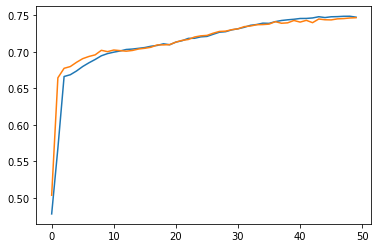

In [25]:
data_variables_reduced = np.array(data[:, :2])
train_reduced()

Run the following code snippets. They will produce heat maps of the NN output, first order gradients and the jacobian matrix. Inpect the results and understand them.

In [27]:
model = load_model('model_reduced.hd5')

f = []
d1 = []
d2 = []
dd1 = []
dd2 = []
d1d2 = []

for i in range(40):
    lf = []
    ld1 = []
    ld2 = []
    ldd1 = []
    ldd2 = []
    ld1d2 = []
    for j in range(40):
        point = np.array([5.-i/40.*7., j/40.*7.-2.]) #decreasing in i because of image coordinate system of imshow
        with tensorflow.GradientTape() as tape2:
            with tensorflow.GradientTape() as tape: #https://www.tensorflow.org/guide/advanced_autodiff#higher-order_gradients
                inputs = tensorflow.Variable([point])
                tape.watch(inputs)
                tape2.watch(inputs)
                output = model(inputs)
            g1 = tape.gradient(output, inputs)
            grads = g1.numpy()[0]
        grads2 = tape2.jacobian(g1, inputs).numpy()[0]
        lf.append(output.numpy()[0])
        ld1.append(grads[0])
        ld2.append(grads[1])
        ldd1.append(grads2[0][0][0])
        ldd2.append(grads2[1][0][1])
        ld1d2.append(grads2[1][0][0])
    f.append(lf)
    d1.append(ld1)
    d2.append(ld2)
    dd1.append(ldd1)
    dd2.append(ldd2)
    d1d2.append(ld1d2)



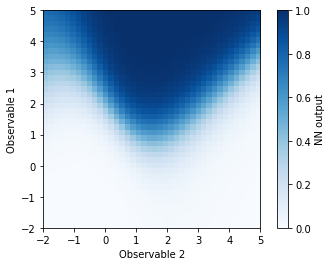

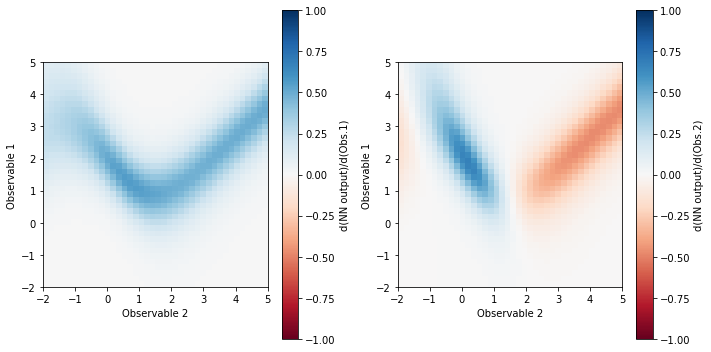

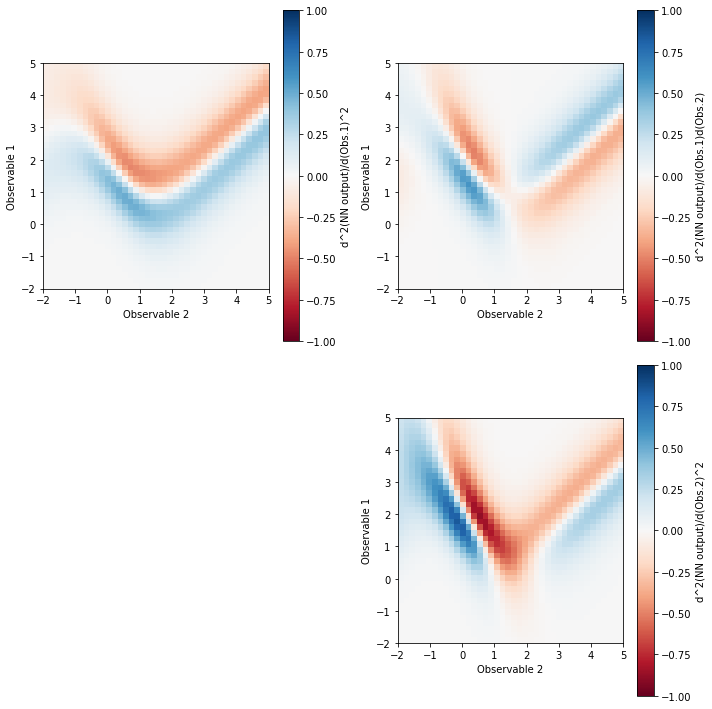

In [31]:
# plot NN output function
plt.imshow(f, extent=[-2,5,-2,5], cmap='Blues', vmin=0.0, vmax=1.0)
plt.xlabel("Observable 2")
plt.ylabel("Observable 1")
plt.colorbar(label="NN output")
plt.show()

# plot first derivatives
fig, axarr = plt.subplots(1, 2, figsize=[10, 5])
pcm = axarr[0].imshow(d1, extent=[-2,5,-2,5], cmap='RdBu', vmin=-1.0, vmax=1.0)
axarr[0].set_xlabel("Observable 2")
axarr[0].set_ylabel("Observable 1")
fig.colorbar(pcm, ax=axarr[0], label="d(NN output)/d(Obs.1)")
axarr[1].imshow(d2, extent=[-2,5,-2,5], cmap='RdBu', vmin=-1.0, vmax=1.0)
axarr[1].set_xlabel("Observable 2")
axarr[1].set_ylabel("Observable 1")
fig.colorbar(pcm, ax=axarr[1], label="d(NN output)/d(Obs.2)")
plt.tight_layout()
plt.show()

# plot second derivatives
fig, axarr = plt.subplots(2, 2, figsize=[10, 10])
pcm2 = axarr[0,0].imshow(dd1, extent=[-2,5,-2,5], cmap='RdBu', vmin=-1.0, vmax=1.0)
axarr[0,0].set_xlabel("Observable 2")
axarr[0,0].set_ylabel("Observable 1")
fig.colorbar(pcm2, ax=axarr[0,0], label="d^2(NN output)/d(Obs.1)^2")
axarr[0,1].imshow(d1d2, extent=[-2,5,-2,5], cmap='RdBu', vmin=-1.0, vmax=1.0)
axarr[0,1].set_xlabel("Observable 2")
axarr[0,1].set_ylabel("Observable 1")
fig.colorbar(pcm2, ax=axarr[0,1], label="d^2(NN output)/d(Obs.1)d(Obs.2)")
axarr[1,1].imshow(dd2, extent=[-2,5,-2,5], cmap='RdBu', vmin=-1.0, vmax=1.0)
axarr[1,1].set_xlabel("Observable 2")
axarr[1,1].set_ylabel("Observable 1")
fig.colorbar(pcm2, ax=axarr[1,1], label="d^2(NN output)/d(Obs.2)^2")
axarr[1,0].axis('off')
plt.tight_layout()
plt.show()

Finally, think about what impacts the gradient based key figures. In case of effects that deteriorate the interpretability, can you think of measures to mitigate these effects?

<span style="color:red">A central aspect that should be named here is that the scale of the variables plays an important role. Units are neglected and for comparability quantities should be preprocessed to have same variance or sth. similar.</span>